In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("satyamkahali/tea-disease-leaf-dataset")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/tea-disease-leaf-dataset


In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import torch.optim as optim
import torch.nn as nn
from torchvision import transforms,datasets
from sklearn.metrics import precision_score,recall_score,f1_score,accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [3]:
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),              # Resize to desired dimensions
    transforms.RandomHorizontalFlip(),         # Apply horizontal flip
    transforms.RandomVerticalFlip(),           # Apply vertical flip
    transforms.RandomInvert(),                 # Invert colors
    transforms.RandomRotation(degrees=90),     # Randomly rotate 90 degrees
    transforms.ToTensor(),                     # Convert PIL image to tensor
    transforms.Normalize(mean=[-0.0038, -0.0038, -0.0039], std=[0.0235, 0.0226, 0.0261]),  # Normalize tensor
])

val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),             # Resize for validation
    transforms.ToTensor(),                     # Convert PIL image to tensor
     transforms.Normalize(mean=[-0.0038, -0.0038, -0.0039], std=[0.0235, 0.0226, 0.0261]),  # Normalize tensor
])

In [5]:
from torch.utils.data import DataLoader
import os
import shutil
#specific directories
base_dir='/kaggle/input/tea-disease-leaf-dataset/Tea_Leaf_Disease'
train_dir=os.path.join(base_dir,'Train')
val_dir=os.path.join(base_dir,'Val')
test_dir=os.path.join(base_dir,'Test')

In [6]:
from torchvision.datasets import ImageFolder

train_data=ImageFolder(root=train_dir,transform=train_transforms)
val_data=ImageFolder(root=val_dir,transform=val_transforms)
test_data=ImageFolder(root=test_dir,transform=val_transforms)

In [7]:
train_loader= DataLoader(train_data,batch_size=32,shuffle=True)
val_loader=DataLoader(val_data,batch_size=32,shuffle=False)
test_loader=DataLoader(test_data,batch_size=32,shuffle=False)

In [8]:
# Hyperparameters
batch_size = 32
learning_rate = 0.001
num_epochs = 50

In [9]:
# Define ResNet50 model for classification using pretrained weights
import torchvision.models as models
import torch.nn as nn

class ResNet50Classifier(nn.Module):
    def __init__(self, num_classes=6):
        super(ResNet50Classifier, self).__init__()
        self.resnet = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)  # Use pretrained weights
        for param in self.resnet.parameters():
            param.requires_grad = False  # Freeze all layers initially
        self.resnet.fc = nn.Linear(2048, num_classes)  # Replace FC layer

    def forward(self, x):
        return self.resnet(x)

In [10]:
pip install tqdm

Note: you may need to restart the kernel to use updated packages.


In [11]:
model = ResNet50Classifier(num_classes=6)
model = model.to(device)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 189MB/s] 


In [12]:
#Using crossentropy loss for multi class classification
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-4)


In [13]:
def train(model,train_loader,val_loader,device=device):
  criterion=criterion
  optimizer=optimizer

   # Track metrics
  train_loss, val_loss = [], []
  train_accuracy, val_accuracy = []
  precision_scores, recall_scores, f1_scores = [], [], []


In [14]:
from tqdm import tqdm
# Initialize metrics
train_loss, val_loss = [], []
train_accuracy, val_accuracy = [0] , [0]
precision_scores, recall_scores, f1_scores = [], [], []
#  training loop
epoch = 0
for epochs in range(num_epochs):  
    model.train()  # Set model to training mode
    epoch_loss = 0.0
    correct_train = 0
    total_train = 0

    # tqdm progress bar
    loop = tqdm(train_loader, total=len(train_loader), leave=False)
    for inputs, labels in loop:
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Update metrics
        epoch_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct_train += (predicted == labels).sum().item()
        total_train += labels.size(0)

        # Update tqdm description
        loop.set_description(f"Epoch [{epoch + 1}]")
        loop.set_postfix(loss=loss.item())

    # Training statistics
    train_loss.append(epoch_loss / len(train_loader))
    train_accuracy.append(100 * correct_train / total_train)

    # Validation Loop
    model.eval()  # Set model to evaluation mode
    val_epoch_loss = 0.0
    correct_val = 0
    total_val = 0
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            val_epoch_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct_val += (predicted == labels).sum().item()
            total_val += labels.size(0)

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

    # Validation metrics
    val_loss.append(val_epoch_loss / len(val_loader))
    val_accuracy.append(100 * correct_val / total_val)
    precision_scores.append(precision_score(all_labels, all_preds, average='weighted', zero_division=1))
    recall_scores.append(recall_score(all_labels, all_preds, average='weighted', zero_division=1))
    f1_scores.append(f1_score(all_labels, all_preds, average='weighted', zero_division=1))

    print(f"Epoch {epoch + 1}, Train Loss: {train_loss[-1]:.4f}, Val Loss: {val_loss[-1]:.4f}, Train Accuracy: {train_accuracy[-1]:.2f}%, Val Accuracy: {val_accuracy[-1]:.2f}%")

    epoch += 1

print(f"Training finished")

# Define the folder path in Kaggle output
output_folder = '/kaggle/working/saved_models_weights'

# Create the folder if it doesn't exist
os.makedirs(output_folder, exist_ok=True)

# Save the model weights in the created folder
save_path = os.path.join(output_folder, 'Tea_Leaf_model.pth')
torch.save(model.state_dict(), save_path)
print(f"Model weights saved to {save_path}")

Epoch 1, Train Loss: 1.6590, Val Loss: 1.4839, Train Accuracy: 45.33%, Val Accuracy: 73.06%


Epoch 2, Train Loss: 1.3975, Val Loss: 1.2987, Train Accuracy: 67.60%, Val Accuracy: 71.04%


Epoch 3, Train Loss: 1.2237, Val Loss: 1.1475, Train Accuracy: 72.95%, Val Accuracy: 73.40%


Epoch 4, Train Loss: 1.1086, Val Loss: 1.0755, Train Accuracy: 74.53%, Val Accuracy: 73.23%


Epoch 5, Train Loss: 1.0219, Val Loss: 0.9884, Train Accuracy: 76.26%, Val Accuracy: 76.26%


Epoch 6, Train Loss: 0.9598, Val Loss: 0.9117, Train Accuracy: 76.45%, Val Accuracy: 75.25%


Epoch 7, Train Loss: 0.8987, Val Loss: 0.9306, Train Accuracy: 78.15%, Val Accuracy: 76.26%


Epoch 8, Train Loss: 0.8642, Val Loss: 0.8386, Train Accuracy: 77.34%, Val Accuracy: 76.09%


Epoch 9, Train Loss: 0.8287, Val Loss: 0.8219, Train Accuracy: 78.88%, Val Accuracy: 76.77%


Epoch 10, Train Loss: 0.7971, Val Loss: 0.8159, Train Accuracy: 79.31%, Val Accuracy: 77.44%


Epoch 11, Train Loss: 0.7735, Val Loss: 0.7495, Train Accuracy: 79.82%, Val Accuracy: 77.78%


Epoch 12, Train Loss: 0.7348, Val Loss: 0.7423, Train Accuracy: 80.99%, Val Accuracy: 78.11%


Epoch 13, Train Loss: 0.7318, Val Loss: 0.7537, Train Accuracy: 80.22%, Val Accuracy: 76.60%


Epoch 14, Train Loss: 0.7141, Val Loss: 0.7062, Train Accuracy: 80.58%, Val Accuracy: 77.78%


Epoch 15, Train Loss: 0.6891, Val Loss: 0.6847, Train Accuracy: 81.18%, Val Accuracy: 78.45%


Epoch 16, Train Loss: 0.6821, Val Loss: 0.6749, Train Accuracy: 81.07%, Val Accuracy: 79.80%


Epoch 17, Train Loss: 0.6679, Val Loss: 0.6816, Train Accuracy: 82.03%, Val Accuracy: 77.95%


Epoch 18, Train Loss: 0.6650, Val Loss: 0.6599, Train Accuracy: 81.31%, Val Accuracy: 79.97%


Epoch 19, Train Loss: 0.6482, Val Loss: 0.6499, Train Accuracy: 81.20%, Val Accuracy: 80.13%


Epoch 20, Train Loss: 0.6330, Val Loss: 0.6213, Train Accuracy: 82.10%, Val Accuracy: 80.47%


Epoch 21, Train Loss: 0.6360, Val Loss: 0.6213, Train Accuracy: 82.33%, Val Accuracy: 80.81%


Epoch 22, Train Loss: 0.6155, Val Loss: 0.6258, Train Accuracy: 81.84%, Val Accuracy: 79.63%


Epoch 23, Train Loss: 0.6085, Val Loss: 0.6160, Train Accuracy: 82.57%, Val Accuracy: 80.64%


Epoch 24, Train Loss: 0.6144, Val Loss: 0.6165, Train Accuracy: 82.14%, Val Accuracy: 79.63%


Epoch 25, Train Loss: 0.5988, Val Loss: 0.5896, Train Accuracy: 82.82%, Val Accuracy: 81.99%


Epoch 26, Train Loss: 0.5742, Val Loss: 0.6212, Train Accuracy: 83.29%, Val Accuracy: 79.80%


Epoch 27, Train Loss: 0.5853, Val Loss: 0.6034, Train Accuracy: 82.78%, Val Accuracy: 80.47%


Epoch 28, Train Loss: 0.5757, Val Loss: 0.5959, Train Accuracy: 82.57%, Val Accuracy: 79.80%


Epoch 29, Train Loss: 0.5669, Val Loss: 0.5922, Train Accuracy: 83.53%, Val Accuracy: 81.48%


Epoch 30, Train Loss: 0.5654, Val Loss: 0.5787, Train Accuracy: 83.16%, Val Accuracy: 80.47%


Epoch 31, Train Loss: 0.5438, Val Loss: 0.5546, Train Accuracy: 84.21%, Val Accuracy: 81.99%


Epoch 32, Train Loss: 0.5591, Val Loss: 0.5677, Train Accuracy: 82.76%, Val Accuracy: 81.99%


Epoch 33, Train Loss: 0.5521, Val Loss: 0.5608, Train Accuracy: 82.95%, Val Accuracy: 81.48%


Epoch 34, Train Loss: 0.5257, Val Loss: 0.5372, Train Accuracy: 84.59%, Val Accuracy: 82.66%


Epoch 35, Train Loss: 0.5406, Val Loss: 0.5480, Train Accuracy: 83.59%, Val Accuracy: 81.65%


Epoch 36, Train Loss: 0.5423, Val Loss: 0.5599, Train Accuracy: 83.72%, Val Accuracy: 81.31%


Epoch 37, Train Loss: 0.5385, Val Loss: 0.5564, Train Accuracy: 84.42%, Val Accuracy: 83.33%


Epoch 38, Train Loss: 0.5341, Val Loss: 0.5420, Train Accuracy: 83.87%, Val Accuracy: 83.16%


Epoch 39, Train Loss: 0.5253, Val Loss: 0.5345, Train Accuracy: 84.16%, Val Accuracy: 81.82%


Epoch 40, Train Loss: 0.5152, Val Loss: 0.5220, Train Accuracy: 84.59%, Val Accuracy: 81.65%


Epoch 41, Train Loss: 0.5102, Val Loss: 0.5253, Train Accuracy: 84.21%, Val Accuracy: 82.66%


Epoch 42, Train Loss: 0.5207, Val Loss: 0.5918, Train Accuracy: 83.99%, Val Accuracy: 81.31%


Epoch 43, Train Loss: 0.5073, Val Loss: 0.5205, Train Accuracy: 84.48%, Val Accuracy: 82.83%


Epoch 44, Train Loss: 0.5079, Val Loss: 0.5179, Train Accuracy: 83.89%, Val Accuracy: 82.32%


Epoch 45, Train Loss: 0.5030, Val Loss: 0.5022, Train Accuracy: 84.78%, Val Accuracy: 83.16%


Epoch 46, Train Loss: 0.5067, Val Loss: 0.5114, Train Accuracy: 84.65%, Val Accuracy: 81.99%


Epoch 47, Train Loss: 0.5003, Val Loss: 0.5135, Train Accuracy: 84.83%, Val Accuracy: 82.49%


Epoch 48, Train Loss: 0.4938, Val Loss: 0.5211, Train Accuracy: 84.78%, Val Accuracy: 83.84%


Epoch 49, Train Loss: 0.4986, Val Loss: 0.4931, Train Accuracy: 84.65%, Val Accuracy: 84.18%


Epoch 50, Train Loss: 0.5015, Val Loss: 0.5054, Train Accuracy: 84.91%, Val Accuracy: 83.16%
Training finished
Model weights saved to /kaggle/working/saved_models_weights/Tea_Leaf_model.pth


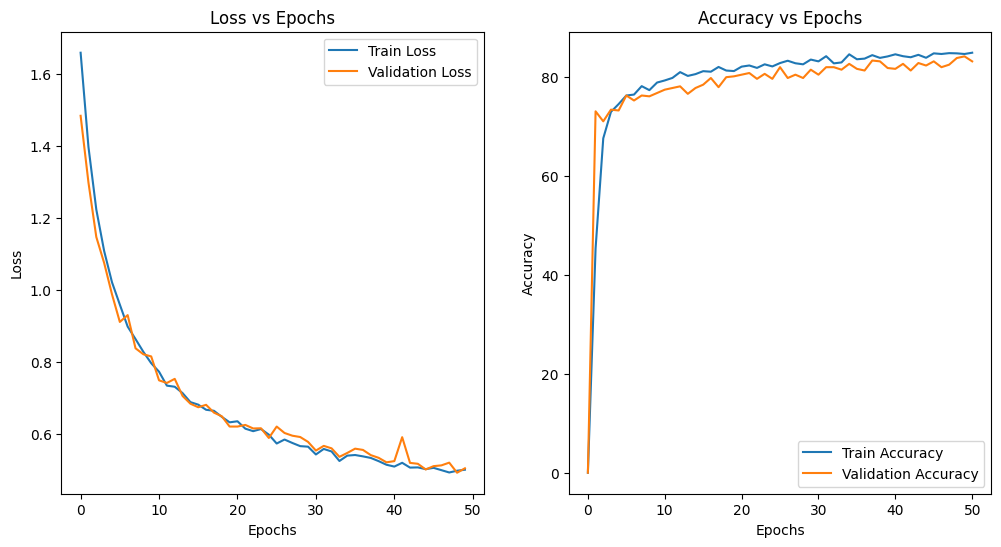

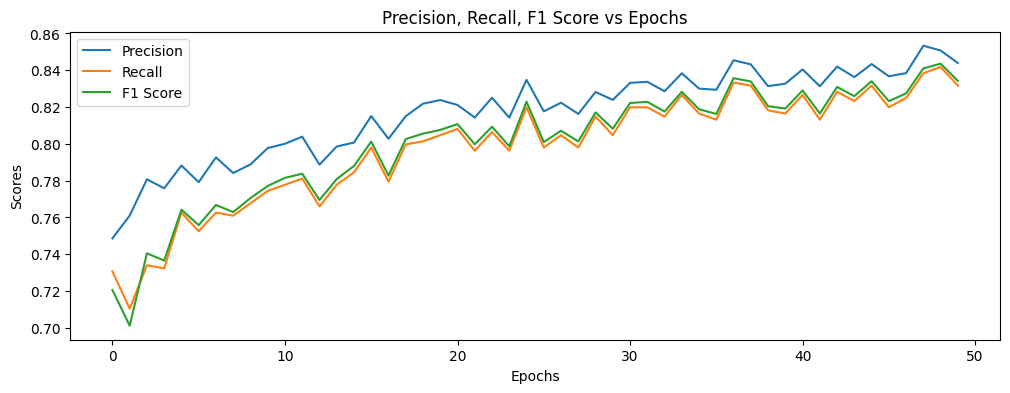

In [21]:
def plot_metrics(train_loss, val_loss, train_accuracy, val_accuracy, precision, recall, f1):
    # Plot loss
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(train_loss, label='Train Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss vs Epochs')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracy, label='Train Accuracy')
    plt.plot(val_accuracy, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Accuracy vs Epochs')
    plt.legend()
    plt.show()

    # Plot Precision, Recall, F1-Score
    plt.figure(figsize=(12, 4))
    plt.plot(precision, label='Precision')
    plt.plot(recall, label='Recall')
    plt.plot(f1, label='F1 Score')
    plt.xlabel('Epochs')
    plt.ylabel('Scores')
    plt.title('Precision, Recall, F1 Score vs Epochs')
    plt.legend()
    plt.show()

plot_metrics(train_loss, val_loss, train_accuracy, val_accuracy, precision_scores, recall_scores, f1_scores)


In [19]:
class ResNet50Classifier(nn.Module):
    def __init__(self, num_classes=6):  # Change num_classes to 6
        super(ResNet50Classifier, self).__init__()
        self.resnet = models.resnet50(weights=None)
        self.resnet.fc = nn.Linear(2048, num_classes)  # For 6 classes instead of 8

    def forward(self, x):
        return self.resnet(x)

# Load the model and weights
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ResNet50Classifier(num_classes=6)  # Match num_classes with the saved model
model.load_state_dict(torch.load('/kaggle/working/saved_models_weights/Tea_Leaf_model.pth'))
model.to(device)
model.eval()


<ipython-input-19-bbfd56eab023>:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/kaggle/working/saved_models_weights/Tea_Leaf_model.pth')

ResNet50Classifier(
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(


Test Accuracy: 85.03%

Classification Report:
               precision    recall  f1-score   support

     Class 1       0.99      0.81      0.89        99
     Class 2       0.70      0.86      0.77        86
     Class 3       0.78      0.81      0.80        99
     Class 4       0.88      0.94      0.91        99
     Class 5       0.84      0.93      0.88        99
     Class 6       0.96      0.76      0.85        99

    accuracy                           0.85       581
   macro avg       0.86      0.85      0.85       581
weighted avg       0.86      0.85      0.85       581


F1 Score (Weighted): 0.8515


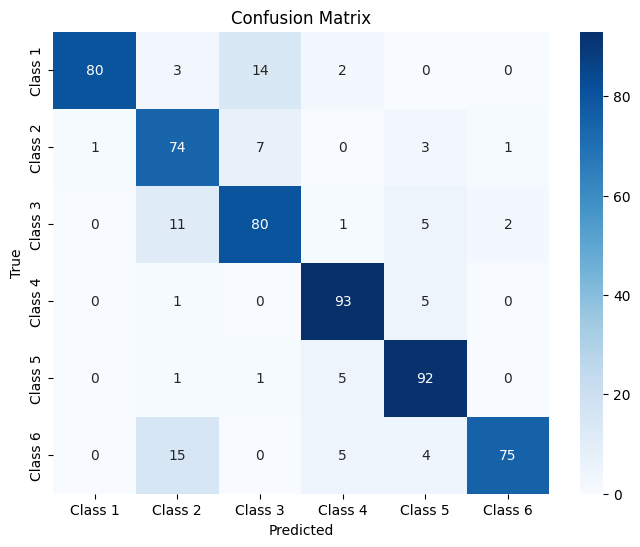

In [23]:
import torch
from sklearn.metrics import classification_report, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score
# Define the DataLoader for the test set 
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

# Evaluate the model on the test set
all_labels = []
all_preds = []

with torch.no_grad():  # No need to calculate gradients during evaluation
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)

        # Collecting all labels and predictions for metrics
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())

# Calculate accuracy
accuracy = accuracy_score(all_labels, all_preds)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

# Classification report
class_report = classification_report(all_labels, all_preds, target_names=['Class 1', 'Class 2', 'Class 3', 'Class 4', 'Class 5', 'Class 6'])
print("\nClassification Report:\n", class_report)

# Compute F1 score (weighted average)
f1 = f1_score(all_labels, all_preds, average='weighted')  # You can also try 'macro'
print(f'\nF1 Score (Weighted): {f1:.4f}')

# Confusion matrix
conf_matrix = confusion_matrix(all_labels, all_preds)

# Visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 1', 'Class 2', 'Class 3', 'Class 4', 'Class 5', 'Class 6'], 
            yticklabels=['Class 1', 'Class 2', 'Class 3', 'Class 4', 'Class 5', 'Class 6'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()